# Immigration in Europe

### Legend:
- h2: each person's contribution
- h3: individual work sections

In [2]:
# importing libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import numpy as np
import seaborn as sns

import geopandas
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import Markdown

## Jakub 

### Foregin born residents in country

In [2]:
url = "https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/Annual_population_eurostat(mandatory).csv"
table = pd.read_csv(url)
year_offset = 4

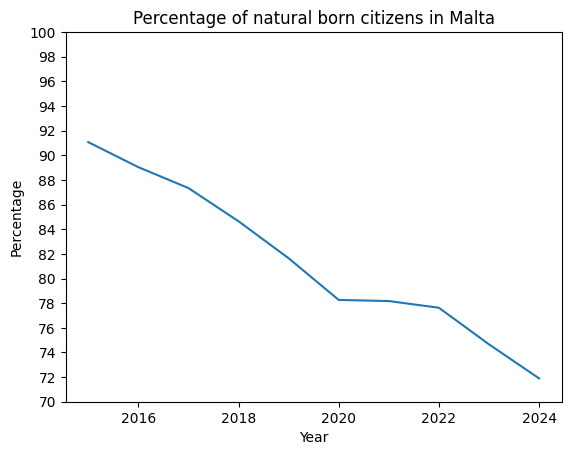

In [3]:
def percent_natural_born(country,title):
    pop_new = []
    country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
    country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")

    try:
        for i in range(10):
            pop_new.append(country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100)

        dataframe = pd.DataFrame({'year': range(2015,2025,1),
                           'percentage': pop_new})

        figure, axes = plt.subplots()
        axes.plot(dataframe['year'], dataframe['percentage'])

        axes.set_xlabel('Year')
        axes.set_ylabel('Percentage')
        
        

        y_min = 70
        step = 2
        
        if min(dataframe["percentage"]<y_min):
            y_min = 50

        axes.set_ylim(y_min)
        axes.set_yticks(range(y_min,100+step,step))

        axes.set_title(title)
        
        #Saving figure
        # These lines are commented for demonstration purposes

        # dir_name = "../Images/Countries/"+country
        # try:
        #     os.makedirs(dir_name)
        #     # print(f"Directory '{dir_name}' created successfully!")
        # except FileExistsError:
        #     pass
        #     # print(f"Directory '{dir_name}' already exists.")
        # except Exception as e:
        #     pass
        #     # print(f"Error creating directory: {e}")
        
        # figure.savefig(dir_name+"/natural_percent_"+country.lower()+".png")
        # plt.close(figure)
        pass
    except Exception as e:
            print("Unable to process",country,":",e)

# display(table.query("Country == 'Malta' and sex=='T'"))
percent_natural_born("Malta",'Percentage of natural born citizens in Malta')


### Getting ratios of people of type over the years


- Result is rounded to 2 decimal places


Documentation:
- get_ratio_dataframe expects one argument: *citizenship_type*. if left **None**, it will calculate all foreigners.
- citizenship_type can be in
    - **EU28_FOR**: EU28 countries (2013-2020) except reporting country
    - **NEU28_FOR**: Non-EU28 countries (2013-2020) nor reporting country
    - **NAT**: Reporting country
    - **STLS**: Stateless
    - **TOTAL**: Total
    - **UNK**: Unknown
    

In [4]:
def get_citizenship_ratio(country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        # print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_ratio(country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Get total amount for type


In [5]:
def get_citizenship_total(country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((country_main.iloc[0,year_offset + i]-country_natural.iloc[0,year_offset + i]))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        # commented out for presentation purposes
        # print("Error processing country: ",country)
        return None
    
def get_total_dataframe(citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_total(country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Get absolute change for type

In [6]:
def get_change_total(year1,year2,citizenship_type=None):
    #gets the original table from get_total_dataframe
    original_table = get_total_dataframe(citizenship_type)
    # display(original_table.head())

    change_dict = dict()

    for index,row in original_table.reset_index().iterrows():
        # print(type(row))
        # print(row["ISO3"],row[str(year2)]-row[str(year1)])
        change_dict[row["ISO3"]] = row[str(year2)]-row[str(year1)]

    
    change_df = pd.DataFrame(list(change_dict.items()), columns=["ISO3", "Change"])#I used ChatGPT for this line

    change_df.set_index("ISO3", inplace=True)
    return change_df


### Europe map drawing function

#### Documentation
- draw_choropleth accepts 4 arguments:
    - data: data
    - column: color of countries
    - range = **None**: range of color, set to auto by default
    - save_name = **None**: name of destination file, not exporting by default
    - color_scheme = **None**: color scheme made out of color names/hex values. *Plasna* by default

In [7]:
def draw_choropleth(data, column,range=None,save_name=None,title="",color_scheme=None):
  if color_scheme is None:
    cmap = "Plasma"
  else:
    cmap = color_scheme
    
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range,
      color_continuous_scale=cmap
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      color_continuous_scale=cmap
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  
  
  
  #I used Deepseek AI to write this code
  if save_name:
    try:
      fig.write_image(f"../Images/Maps/{save_name}.png", scale=4)
      print(f"Successfully saved to {save_name}.png")
    except Exception as e:
      print(f"Could not save PNG: {str(e)}")
      print("Install kaleido with: pip install -U kaleido")
  else:
    fig.show()

  

#### Drawing

In [8]:
# Percentage of EU born
display_countries = get_ratio_dataframe("EU28_FOR")
year = 2020
title="Percentage of immigrants born in EU countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,30),None,title)

# Percentage of non-EU born

display_countries = get_ratio_dataframe("NEU28_FOR")
year = 2020
title="Percentage of non-EU immigrants countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,15),None,title)

display_countries = get_total_dataframe("EU28_FOR")
year = 2020
title="Total number of immigrants born in EU countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,4.5e6),None,title)

year1 = 2015
year2 = 2020
display_countries = get_change_total(year1,year2,"EU28_FOR")
title="Change of immigrants from EU countries between "+str(year1) +" and "+str(year2)

draw_choropleth(display_countries, "Change",(0,1e6), None,title)


### District information in Slovakia

In [10]:
net_migration_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/net_migration_districts_sk.csv")
unemployment_migration_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/unemployment_districts_sk.csv")
monthly_salary_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/average_montly_salary_districts_sk.csv")


districts_geodata = geopandas.read_file("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/geography/slovak_districts.json")


districts_net_migration = pd.merge(districts_geodata,net_migration_raw,on="LAU1_CODE")
districts_unemployment = pd.merge(districts_geodata,unemployment_migration_raw,on="LAU1_CODE")
districts_salary = pd.merge(districts_geodata,monthly_salary_raw,on="LAU1_CODE")



#### Largest/smallest value in counties

In [11]:
def district_value_total(table,ascending = True):
    data = []
    
    for index,row in table.iterrows():
        name = row["NM3"]
        geography = row["geometry"]
        total = 0
        for year in range(1995,2024,1):
            total += row[str(year)]

        data.append({"District":name,
                     "geometry":geography,
                     "value":total})
    result_df = geopandas.GeoDataFrame(data)
    result_df.sort_values(by="value",ascending=ascending,inplace=True)
    # display(result_df.head())
    return result_df

# district_value_total(districts_net_migration,ascending=False)

### Slovakia district drawing function

In [12]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_districts(table, target_column, title_label="", colorbar_label="Value",fixed_max_value=None,fixed_min_value=None,filename="",color_scheme = ["red", "lightgray", "green"],biggest_text="Biggest net gain",smallest_text = "Biggest net loss"):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if fixed_max_value is None:
        max_value = max([abs(x) for x in table[target_column]])
        # print("Max value: ",max_value)
    else:
        max_value = fixed_max_value
    

    cmap = LinearSegmentedColormap.from_list("red_green", color_scheme)
    if fixed_min_value is None:
        min_value = -max_value
    elif fixed_min_value == "min":
        min_value = min([x for x in table[target_column]])
        # print(min_value)

    else:
        min_value = fixed_min_value
    
    norm = Normalize(vmin=min_value,vmax=max_value)

    # axes = table.plot(column = target_column,legend=True,cmap=cmap,norm=norm,edgecolor="gray",linewidth=0.3)

    table.plot(
        column=target_column,
        cmap=cmap,
        norm=norm,
        edgecolor="gray",
        linewidth=0.3,
        ax=ax,
        legend=False
    )

    # I used ChatGPT to write this paragraph of code
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(colorbar_label, fontsize=10)


    ax.set_title(title_label, fontsize=18,  pad=15)
    ax.set_axis_off()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    #Net gain and loss
    gain_table = table.sort_values(str(target_column),ascending=False).head()
    
    loss_table = table.sort_values(str(target_column),ascending=True).head()

    #constant, change here:
    n_districts = 5
    gain = []
    loss = []
    
    for i in range(n_districts):
        gain.append((gain_table.iloc[i,0],float(gain_table.iloc[i,:][str(target_column)])))
        loss.append((loss_table.iloc[i,0],float(loss_table.iloc[i,:][str(target_column)])))
    
    gain_text = rf"$\bf { "\\ ".join(biggest_text.split())}$"+"\n"

    for district,value in gain:
        gain_text += district + ": "+ f"{value:.1f}" + "\n"
    
    loss_text = rf"$\bf {"\\ ".join(smallest_text.split())}$"+"\n"
    for district,value in loss:
        loss_text += district + ": "+ f"{value:.1f}" + "\n"

    plt.figtext(0.4, 0.1, gain_text, ha='left', fontsize=9, wrap=False)
    plt.figtext(0.6, 0.1, loss_text, ha='left', fontsize=9, wrap=False)

    plt.tight_layout()
    if filename != "":
        # os.makedirs("../../Images/Slovakia",exist_ok=True)
        plt.savefig("../../Images/Slovakia/"+filename+".png")
        plt.close()
    else:
        plt.show()

# draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), colorbar_label="Total migration change",filename="")


#### Drawing different maps in 2020

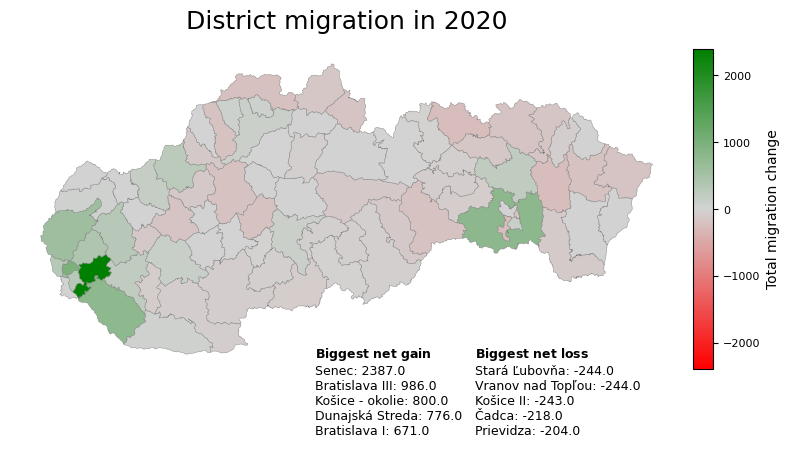

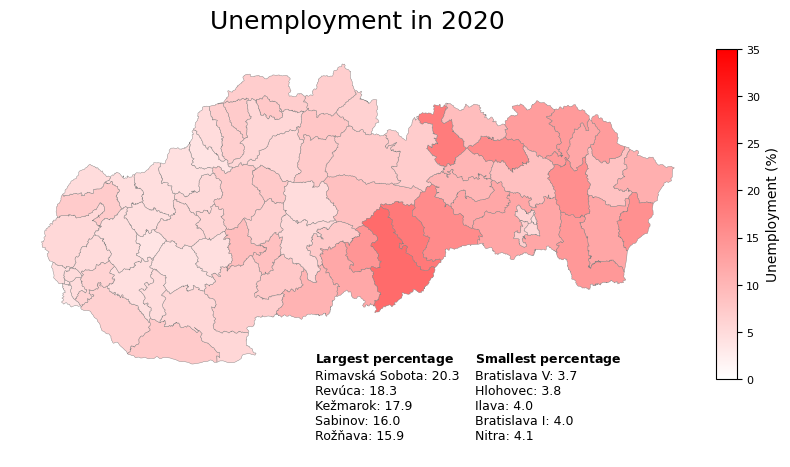

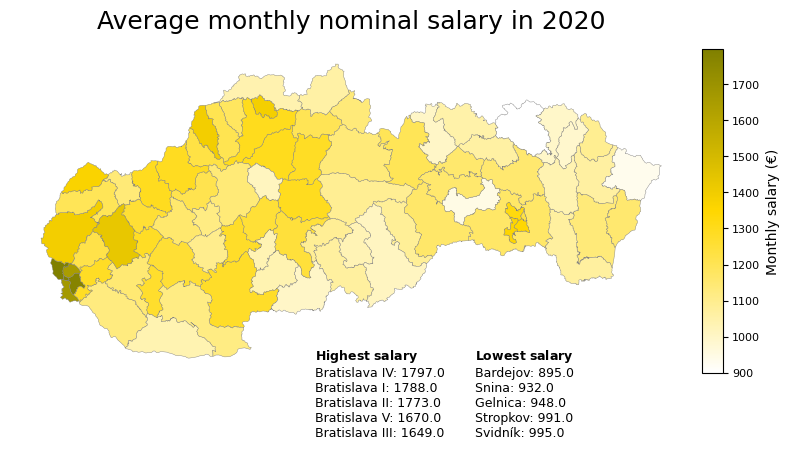

In [13]:
# migration
draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), 
               colorbar_label="Total migration change",filename="")

# unemployment
draw_districts(districts_unemployment, str(2020), title_label="Unemployment in "+str(2020), 
                colorbar_label="Unemployment (%)",fixed_min_value=0,color_scheme=["white","red"],
                biggest_text="Largest percentage",
                smallest_text="Smallest percentage",fixed_max_value=35)

# monthly salary
draw_districts(districts_salary, str(2020), title_label="Average monthly nominal salary in "+str(2020), 
                colorbar_label="Monthly salary (€)",fixed_min_value=900,color_scheme=["white","gold","olive"],
                biggest_text="Highest salary",
                smallest_text="Lowest salary")

#### Drawing total change


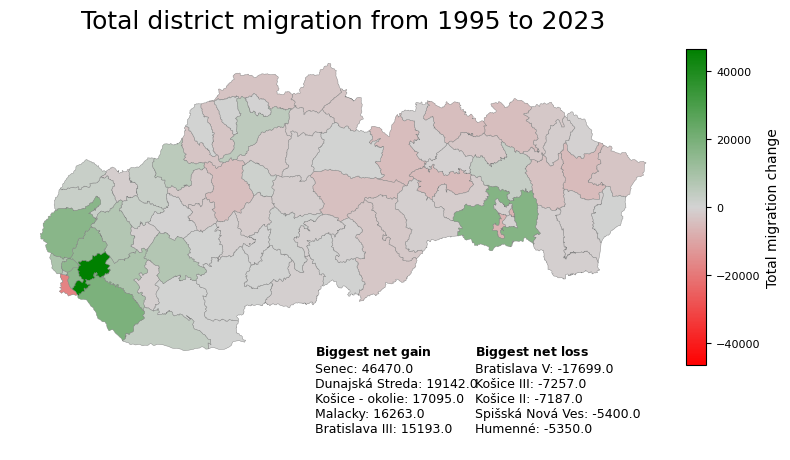

In [14]:
#Total change
total_table = district_value_total(districts_net_migration,True)
# display(total_table.head())
draw_districts(total_table,target_column="value",title_label="Total district migration from 1995 to 2023",colorbar_label="Total migration change",filename="")

# Andrej


### Importing tables

In [15]:
url2 = "https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/immigration/immigration_citizenship.csv"
table2 = pd.read_csv(url2)
display(table2.head())
url1 = "https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/Annual_population_eurostat(mandatory).csv"
table1 = pd.read_csv(url1)
display(table1.head())
year_offset = 4

C:\Users\adami\AppData\Local\Temp\ipykernel_28008\2525204699.py:2: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



,age,agedef,birth_country,sex,Country,ISO3,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,TOTAL,COMPLET,FOR_STLS,F,Austria,AUT,28638.0,35797.0,NaN,34825.0,...,48788.0,65441.0,55097.0,48739.0,45444.0,46329.0,42715.0,46214.0,97378.0,64503.0
1,TOTAL,COMPLET,FOR_STLS,F,Belgium,BEL,29382.0,33021.0,31296.0,39605.0,...,51236.0,56379.0,50222.0,51820.0,55655.0,59833.0,47172.0,55678.0,93814.0,71027.0
2,TOTAL,COMPLET,FOR_STLS,F,Bulgaria,BGR,NaN,NaN,NaN,NaN,...,7295.0,6276.0,5522.0,5844.0,5960.0,6588.0,6190.0,6852.0,8357.0,18085.0
3,TOTAL,COMPLET,FOR_STLS,F,Switzerland,CHE,36508.0,NaN,42245.0,NaN,...,62616.0,61336.0,59968.0,57238.0,57673.0,57407.0,53380.0,57705.0,66610.0,117356.0
4,TOTAL,COMPLET,FOR_STLS,F,Cyprus,CYP,NaN,NaN,NaN,NaN,...,5630.0,7362.0,7437.0,9498.0,10230.0,11953.0,12580.0,11222.0,15632.0,19850.0


,Country,ISO3,citizen,sex,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Austria,AUT,EU28_FOR,F,288028.0,310759.0,329981.0,348012.0,365125.0,383295.0,NaN,NaN,NaN,NaN
1,Belgium,BEL,EU28_FOR,F,416232.0,428008.0,434889.0,440355.0,448655.0,457258.0,NaN,NaN,NaN,NaN
2,Switzerland,CHE,EU28_FOR,F,594052.0,610566.0,622893.0,630371.0,637330.0,645916.0,NaN,NaN,NaN,NaN
3,Cyprus,CYP,EU28_FOR,F,55730.0,57716.0,57673.0,59787.0,63044.0,62935.0,NaN,NaN,NaN,NaN
4,Czechia,CZE,EU28_FOR,F,72465.0,76736.0,81670.0,86132.0,91296.0,96186.0,NaN,NaN,NaN,NaN


### Male and female population in countries 

##### Gender ratio in countries

In [16]:
def gender_ratio(country):
    male_perc = []
    female_perc = []

    country_male = table1.query("Country == '"+country+"' and sex == 'M' and citizen == 'TOTAL'")
    country_female = table1.query("Country == '"+country+"' and sex == 'F' and citizen == 'TOTAL'")
    country_total = table1.query("Country == '"+country+"' and sex == 'T' and citizen == 'TOTAL'")

    try:
        for i in range(10):
            male_val = country_male.iloc[0, i+4]
            female_val = country_female.iloc[0, i+4]
            total_val = country_total.iloc[0, i+4]

            if pd.notnull(male_val) and pd.notnull(female_val) and pd.notnull(total_val) and total_val != 0:
                ratio1 = (male_val / total_val) * 100
                ratio2 = (female_val / total_val) * 100
            else:
                ratio1 = None
                ratio2 = None

            male_perc.append(ratio1)
            female_perc.append(ratio2)

        years = [x for x in range(2015, 2025)]

        figure, axes = plt.subplots()
        axes.plot(years, male_perc, label="Male as % of Total", color="blue")
        axes.plot(years, female_perc, label="Female as % of Total", color="red")
        axes.set_xticks(years)

        axes.set_xlabel('Year')
        axes.set_ylabel('Percentage of population')
        axes.set_title('Male-to-Total and Female-to-Total Population Ratio in ' + country)
        axes.legend()

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)

        file_path = os.path.join(dir_name, f"gender_ratio_{country.lower()}.png")
        figure.savefig(file_path)
        plt.close(figure)

    except Exception as e:
        print(f"Error {country}: {e}")


# generating gender ratio for every possible country from dataset
# for country in table1.Country.unique():
#    gender_ratio(country)

##### Gender count in countries

In [17]:
def gender_count(country):
    male_pop = []
    female_pop = []

    country_male = table1.query("Country == '"+country+"' and sex == 'M' and citizen == 'TOTAL'")
    country_female = table1.query("Country == '"+country+"' and sex == 'F' and citizen == 'TOTAL'")

    try:
        for i in range(10):
            male_pop.append(country_male.iloc[0, i+4])
            female_pop.append(country_female.iloc[0, i+4])


        years = [x for x in range(2015, 2025)]

        figure, axes = plt.subplots()
        axes.plot(years, male_pop, label="Male population", color="blue")
        axes.plot(years, female_pop, label="Female population", color="red")
        axes.set_xticks(years)

        axes.set_xlabel('Year')
        axes.set_ylabel('Population')
        axes.set_title('Total male and female population in ' + country)
        axes.legend()

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)

        file_path = os.path.join(dir_name, f"gender_count_{country.lower()}.png")
        figure.savefig(file_path)
        plt.close(figure)
    except Exception as e:
        print(f"Error {country}: {e}")

# generating gender ratio for every possible country from dataset
# for country in table1.Country.unique():
#    gender_count(country)

##### Total and native citizens

In [18]:
def total_count(country):
    try:
        male_total_data = table1.query("Country == '"+country+"' and sex == 'M' and citizen == 'TOTAL'")
        male_nat_data = table1.query("Country == '"+country+"' and sex == 'M' and citizen == 'NAT'")
        female_total_data = table1.query("Country == '"+country+"' and sex == 'F' and citizen == 'TOTAL'")
        female_nat_data = table1.query("Country == '"+country+"' and sex == 'F' and citizen == 'NAT'")

        if (male_total_data.empty or male_nat_data.empty or
            female_total_data.empty or female_nat_data.empty):
            print(f"Skipping {country}: Missing data for one or more categories")
            return

        male_total = []
        male_nat = []
        female_total = []
        female_nat = []

        try:
            maleN_diff = male_nat_data.iloc[0,-1] - male_nat_data.iloc[0,4]
            femaleN_diff = female_nat_data.iloc[0,-1] - female_nat_data.iloc[0,4]
            maleT_diff = male_total_data.iloc[0,-1] - male_total_data.iloc[0,4]
            femaleT_diff = female_total_data.iloc[0,-1] - female_total_data.iloc[0,4]
        except IndexError:
            print(f"Skipping {country}: Data format doesn't match expectations")
            return

        for i in range(10):
            try:
                male_total.append(male_total_data.iloc[0, i+4])
                male_nat.append(male_nat_data.iloc[0, i+4])
                female_total.append(female_total_data.iloc[0, i+4])
                female_nat.append(female_nat_data.iloc[0, i+4])
            except IndexError:
                print(f"Skipping {country}: Not enough data columns (expected at least {i+5} columns)")
                return

        x = np.arange(10)
        width = 0.2
        years = [x for x in range(2015, 2025)]
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.bar(x - width*1.5, male_total, width, label='Male Total', color='skyblue')
        ax.bar(x - width*0.5, male_nat, width, label='Male Native', color='blue')
        ax.bar(x + width*0.5, female_total, width, label='Female Total', color='lightcoral')
        ax.bar(x + width*1.5, female_nat, width, label='Female Native', color='red')

        ax.set_xlabel('Year')
        ax.set_ylabel('Population')
        ax.set_title(f'Population by Gender and Citizenship Status in {country}')
        ax.set_xticks(x)
        ax.set_xticklabels(years)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        stats_text = (
            f"Change in native male: {int(maleN_diff)} | "
            f"Change in native female: {int(femaleN_diff)} | "
            f"Change in total male: {int(maleT_diff)} | "
            f"Change in total female: {int(femaleT_diff)}"
        )

        fig.text(0.5, -0.1, stats_text, ha='center', fontsize=12, wrap=True)
        plt.subplots_adjust(bottom=0.05)

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)

        file_path = os.path.join(dir_name, f"natives_and_total_count_{country.lower()}.png")
        fig.savefig(f'{file_path}', bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")

# generating total and native citizen counts for every possible country from dataset
# for country in table1.Country.unique():
#    total_count(country)

##### Male-Female immigration ratio -  pie chart

In [19]:
def gender_comparison_pie_chart(country):
    df = table2.copy()

    df = df[(df['birth_country'] == 'FOR_STLS') &
            (df["agedef"] == "REACH") &
            (df['Country'] == country)& 
            (df["age"]=="TOTAL")] 
    

    years = [str(year) for year in range(1998, 2024)]

    for year in years:
        df[year] = pd.to_numeric(df[year], errors='coerce')

    female_total = df[df['sex'] == 'F'][years].sum().sum()
    male_total = df[df['sex'] == 'M'][years].sum().sum()

    if female_total == 0 and male_total == 0:
        print(f"No data found for {country} in period 1998-2023")
        return

    plt.figure(figsize=(8, 8))
    plt.pie([female_total, male_total],
            labels=['Women', 'Men'],
            autopct='%1.1f%%',
            colors=['lightcoral', 'lightblue'],
            startangle=90)

    plt.title(f'Gender Distribution of Immigrants to {country} (1998-2023)')

    stats_text = (
        f"Total immigrants to {country} (1998-2023):\n"
        f"Women: {female_total:,.0f}\n"
        f"Men: {male_total:,.0f}\n"
        f"Total: {female_total + male_total:,.0f}"
    )

    plt.figtext(0.5, 0.05, stats_text, ha='center', fontsize=12, wrap=True)
    plt.tight_layout(pad=3, h_pad=2, w_pad=2)
    dir_name = os.path.join("../Images/Countries", country)
    os.makedirs(dir_name, exist_ok=True)

    file_path = os.path.join(dir_name, f"gender_ratio_immigration_{country.lower()}.png")
    # plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# generating graphs for countries

# for country in table2['Country'].unique():
#     gender_comparison_pie_chart(country)


#### Bargraph and Linegraph of immigrants by age group

##### Bargraph

In [20]:
def country_immigration(country):
    df = table2.copy()
    df = df[(df['birth_country'] == 'TOTAL') & (df["agedef"] == "REACH")]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df = df.dropna(subset=['age'])

    country_data = df[df['Country'] == country]
    # display(country_data)
    try:
        age15 = country_data[(country_data['age'] <= 15) & (country_data['sex'] == 'T')]
        age26 = country_data[(country_data['age'] >= 16) & (country_data['age'] <= 26) & (country_data['sex'] == 'T')]
        age65 = country_data[(country_data['age'] >= 27) & (country_data['age'] <= 65) & (country_data['sex'] == 'T')]
        age100 = country_data[(country_data['age'] >= 66) & (country_data['sex'] == 'T')]


        if len(age15) == 0:
            print(f"No data found for {country} in 0-15 age category")
            return
        elif len(age26) == 0:
            print(f"No data found for {country} in 16-26 age category")
            return
        elif len(age65) == 0:
            print(f"No data found for {country} in 27-65 age category")
            return
        elif len(age100) == 0:
            print(f"No data found for {country} in 66+ age category")
            return

        years = list(range(1998, 2024))
        year_columns = [str(year) for year in years]

        values15 = []
        values26 = []
        values65 = []
        values100 = []
        total15 = 0
        total26 = 0
        total65 = 0
        total100 = 0
        
        for year in year_columns:
            #0-15
            val15 = 0
            if year in age15.columns:
                for value in age15[year]:
                    try:
                        val15 += int(value)
                    except:
                        pass
            
            values15.append(val15)
            total15 += val15

            #16-26
            val26 = 0
            if year in age26.columns:
                for value in age26[year]:
                    try:
                        val26 += int(value)
                    except:
                        pass
            
            values26.append(val26)
            total26 += val26

            #26-65
            val65 = 0
            if year in age65.columns:
                for value in age65[year]:
                    try:
                        val65 += int(value)
                    except:
                        pass
            
            values65.append(val65)
            total65 += val65

            #66+

            val100 = 0
            if year in age100.columns:
                for value in age100[year]:
                    try:
                        val100 += int(value)
                    except:
                        pass
            
            values100.append(val100)
            total100 += val100


        global max_min_tracker
        max_min_tracker['0-15'].update_max_min(country, total15)
        max_min_tracker['16-26'].update_max_min(country, total26)
        max_min_tracker['27-65'].update_max_min(country, total65)
        max_min_tracker['66+'].update_max_min(country, total100)

        stats_text = (
            f"Total immigration by age group in {country}: 0-15: {int(total15):,.0f} | 16-26: {int(total26):,.0f} | 27-65: {int(total65):,.0f} | 66+: {int(total100):,.0f}"
        )

        fig, ax = plt.subplots(figsize=(16, 10))
        plt.subplots_adjust(bottom=0.35)
        bar_width = 0.2

        r1 = np.arange(len(years))
        r2 = [x + bar_width for x in r1]
        r3 = [x + bar_width for x in r2]
        r4 = [x + bar_width for x in r3]

        ax.bar(r1, values15, width=bar_width, label="0-15 years", color="green")
        ax.bar(r2, values26, width=bar_width, label="16-26 years", color="blue")
        ax.bar(r3, values65, width=bar_width, label="27-65 years", color="red")
        ax.bar(r4, values100, width=bar_width, label="66+ years", color="orange")

        ax.set_ylabel('Number of Immigrants')
        ax.set_title(f'Immigration to {country} by Age Group (1998-2023)')
        ax.set_xticks([r + bar_width*1.5 for r in range(len(years))])
        ax.set_xticklabels(years, rotation=45)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=12, wrap=True)
        plt.tight_layout(pad=3, h_pad=2, w_pad=2)

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)

        file_path = os.path.join(dir_name, f"age_groups_immigration_{country.lower()}.png")
        plt.savefig(file_path, bbox_inches='tight')
        plt.close()

        


    except Exception as e:
        print(f"Error processing {country}: {str(e)}")



class MaxMinTracker:
    def __init__(self):
        self.max_country = ""
        self.max_value = 0
        self.min_country = ""
        self.min_value = float('inf')

    def update_max_min(self, country, value):
        if value > self.max_value:
            self.max_value = value
            self.max_country = country
        if value < self.min_value:
            self.min_value = value
            self.min_country = country

max_min_tracker = {
    '0-15': MaxMinTracker(),
    '16-26': MaxMinTracker(),
    '27-65': MaxMinTracker(),
    '66+': MaxMinTracker()
}
# generating graphs for countries

# for country in table2['Country'].unique():
#    country_immigration(country)

country_immigration("Germany")

# print("\nCountries with most and least immigrants by age group (1998-2023):")
# for age_group, tracker in max_min_tracker.items():
#     print(f"{age_group} years: Most - {tracker.max_country} ({int(tracker.max_value)}), "
#           f"Least - {tracker.min_country} ({int(tracker.min_value)})")

##### Linegraph

In [21]:
def country_immigration_linegraph(country):
    df = table2.copy()
    df = df[(df['birth_country'] == 'TOTAL') & (df["agedef"] == "REACH")]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df = df.dropna(subset=['age'])

    country_data = df[df['Country'] == country]

    try:
        age15 = country_data[(country_data['age'] <= 15) & (country_data['sex'] == 'T')]
        age26 = country_data[(country_data['age'] >= 16) & (country_data['age'] <= 26) & (country_data['sex'] == 'T')]
        age65 = country_data[(country_data['age'] >= 27) & (country_data['age'] <= 65) & (country_data['sex'] == 'T')]
        age100 = country_data[(country_data['age'] >= 66) & (country_data['sex'] == 'T')]

        if age15.empty or age26.empty or age65.empty or age100.empty:
            print(f"Missing age group data for {country}")
            return

        years = list(range(1998, 2024))
        year_columns = [str(year) for year in years]

        def collect_values(data, year_columns):
            values = []
            total = 0
            for year in year_columns:
                val = 0
                if year in data.columns:
                    for value in data[year]:
                        try:
                            val += int(value)
                        except:
                            pass
                values.append(val)
                total += val
            return values, total

        values15, total15 = collect_values(age15, year_columns)
        values26, total26 = collect_values(age26, year_columns)
        values65, total65 = collect_values(age65, year_columns)
        values100, total100 = collect_values(age100, year_columns)

        max_min_tracker['0-15'].update_max_min(country, total15)
        max_min_tracker['16-26'].update_max_min(country, total26)
        max_min_tracker['27-65'].update_max_min(country, total65)
        max_min_tracker['66+'].update_max_min(country, total100)

        stats_text = (
            f"Total immigration by age group in {country}: "
            f"0-15: {int(total15):,} | 16-26: {int(total26):,} | "
            f"27-65: {int(total65):,} | 66+: {int(total100):,}"
        )

        fig, ax = plt.subplots(figsize=(16, 10))
        ax.plot(years, values15, label="0-15 years", color="green", marker='o')
        ax.plot(years, values26, label="16-26 years", color="blue", marker='o')
        ax.plot(years, values65, label="27-65 years", color="red", marker='o')
        ax.plot(years, values100, label="66+ years", color="orange", marker='o')

        ax.set_title(f'Immigration to {country} by Age Group (1998-2023)', fontsize=16)
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Immigrants')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

        plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=12, wrap=True)
        plt.tight_layout(pad=3)

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)
        file_path = os.path.join(dir_name, f"linegraph_age_groups_immigration_{country.lower()}.png")
        plt.savefig(file_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")

# generating graphs for countries
# for country in table2['Country'].unique():
#     country_immigration_linegraph(country)

##### Migration pyramid of immigrants by age groups

In [22]:
def country_immigration_pyramid(country):
    df = table2.copy()
    df = df[(df['birth_country'] == 'TOTAL') & (df["agedef"] == "REACH")]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df = df.dropna(subset=['age'])
    country_data = df[df['Country'] == country].copy()

    try:
        bins = list(range(0, 101, 5))
        labels = [f'{bins[i]}-{bins[i + 1] - 1}' for i in range(len(bins) - 1)]

        country_data['age_group'] = pd.cut(country_data['age'], bins=bins, labels=labels, right=False)
        year_columns = [str(year) for year in range(1998, 2024)]

        country_data[year_columns] = country_data[year_columns].apply(pd.to_numeric, errors='coerce')

        age_totals = []
        for group in labels:
            group_data = country_data[country_data['age_group'] == group]
            male_data = group_data[group_data['sex'] == 'M'][year_columns].sum().sum()
            female_data = group_data[group_data['sex'] == 'F'][year_columns].sum().sum()
            if pd.notnull(male_data) and pd.notnull(female_data):
                age_totals.append((group, float(male_data), float(female_data)))

        if not age_totals:
            print(f"No valid data for {country}")
            return

        male_values = [-total[1] for total in age_totals]
        female_values = [total[2] for total in age_totals]
        y_positions = range(len(age_totals))
        age_labels = [total[0] for total in age_totals]

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(y_positions, male_values, align='center', color='blue', label='Male')
        ax.barh(y_positions, female_values, align='center', color='red', label='Female')

        ax.set_yticks(y_positions)
        ax.set_yticklabels(age_labels)
        ax.set_xlabel('Number of Immigrants')
        ax.set_title(f'Population Pyramid for Immigrants in {country}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

        max_val = max(max(abs(m) for m in male_values), max(female_values))
        ax.set_xlim(-max_val * 1.1, max_val * 1.1)

        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{abs(int(x)):,}' for x in xticks])

        plt.tight_layout()

        dir_name = os.path.join("../Images/Countries", country)
        os.makedirs(dir_name, exist_ok=True)
        file_path = os.path.join(dir_name, f"immigration_pyramid_{country.lower()}.png")
        plt.savefig(file_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error processing {country}: {e}")

# generating graphs for countries
# for country in table2['Country'].unique():
#    country_immigration_pyramid(country)

# Adam


### Housing prices

['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia', 'Türkiye', 'United Kingdom', 'Iceland', 'Switzerland']


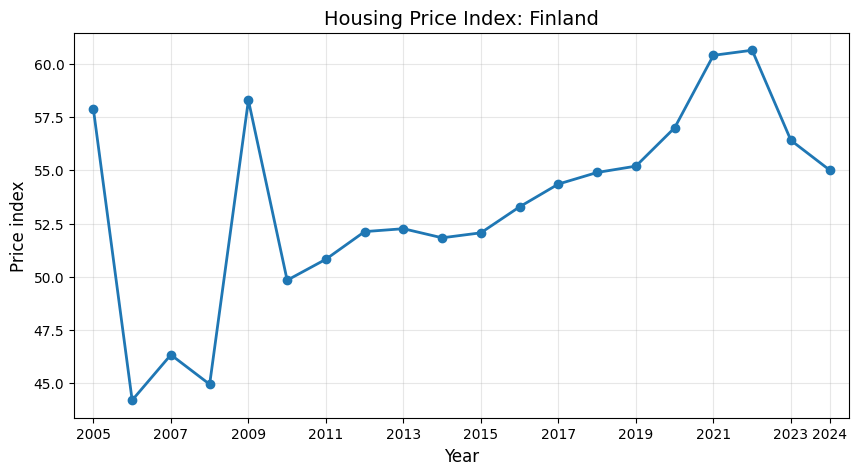

In [ ]:
#each of cells generates only the images used in presentation
house_prices = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/housing_prices.csv")
house_prices = house_prices.drop(columns=["DATAFLOW", "LAST UPDATE", "freq"])
house_prices['Year'] = house_prices['TIME_PERIOD'].str.split('-Q').str[0].astype(int)
house_prices = house_prices[(house_prices['Year'] >= 2005) & (house_prices['Year'] <= 2024)]
yearly_avg = house_prices.groupby(['geo', 'Year'])['OBS_VALUE'].mean().reset_index()
states=house_prices["geo"].unique()
states=[i for i in states if len(i)<35] #ensuring we have proper country names
print(states)

#this code is for creating plot for every country 
for country in states:
    if country=="Finland": #this line and indent is for simplicity of final notebook
        country_data = yearly_avg[yearly_avg['geo'] == country]
        
        if country_data.empty:
            continue  
        
        min_year = min(country_data['Year'].to_list())
        max_year = max(country_data['Year'].to_list())
        year_range = max_year - min_year
        
        plt.figure(figsize=(10, 5))
        plt.plot(country_data['Year'], 
                country_data['OBS_VALUE'], 
                marker='o', 
                linestyle='-', 
                linewidth=2)  
        
        plt.xlim(min_year - 0.5, max_year + 0.5)
        
        if year_range <= 5: 
            step = 1
        else:  
            step = 2
        
        xticks = list(range(min_year, max_year + 1, step))
        if xticks[-1] != max_year:  
            xticks.append(max_year)
        
        plt.xticks(xticks)
        plt.title(f'Housing Price Index: {country}', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Price index', fontsize=12)
        plt.grid(True, alpha=0.3)
        output_dir = os.path.join("..", "Images", "Countries", country)
        file_name = f"housing_prices_change_{country}.png"
        file_path = os.path.join(output_dir, file_name)

        if os.path.isdir(output_dir):
            plt.savefig(file_path)
        else:
            print(f"Directory not found for {country}: {output_dir}")

        plt.show()


### Immigration change

C:\Users\adami\AppData\Local\Temp\ipykernel_28008\2669081730.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



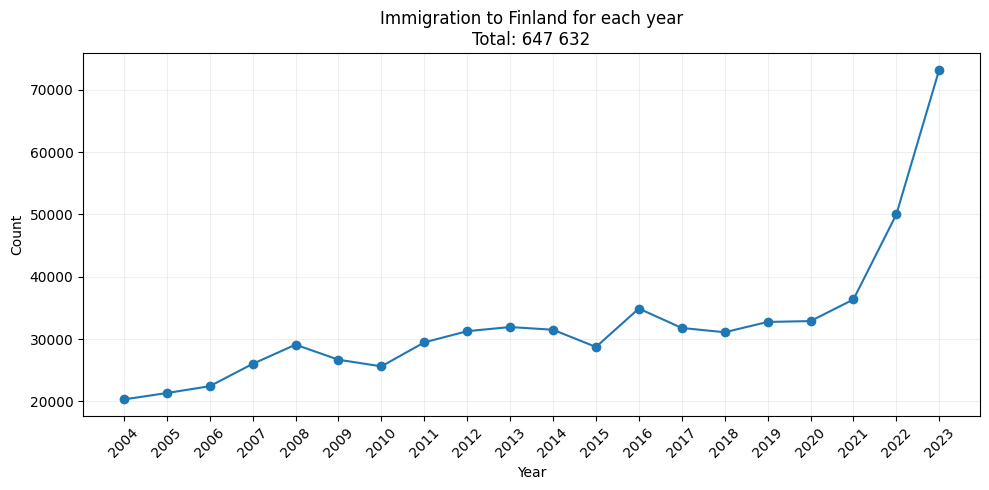

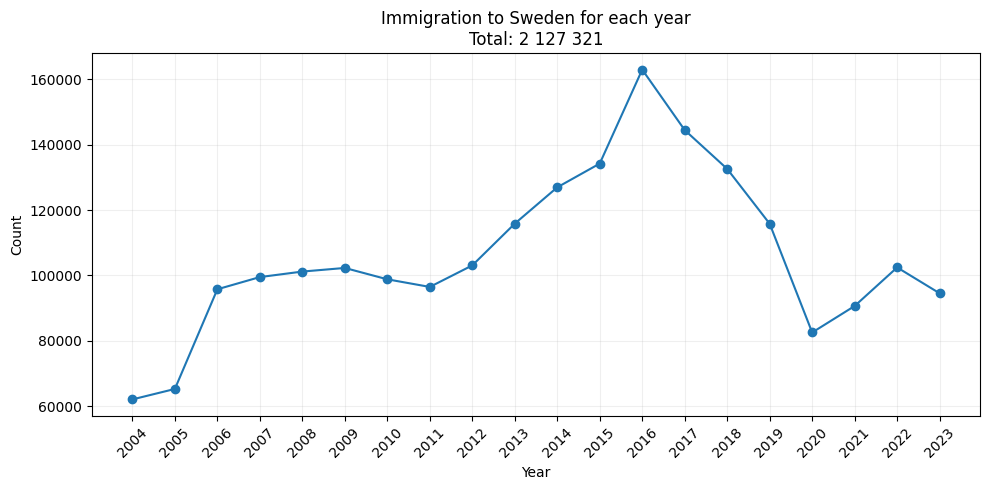

In [ ]:
immigration_count=pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/immigration/immigration_citizenship.csv")
#immigration_count.drop(columns=[str(i) for i in range(1998,2005)])
states_in_second_table=[i for i in immigration_count["Country"].unique() if i in states]
immigration_count.columns = immigration_count.columns.astype(str)

year_cols = [str(y) for y in range(2004, 2024)]


for country in states_in_second_table:
    if country=="Sweden" or country=="Finland": #again for simplicity of the notebook I only want to generate plots used in presentacion 
        country_df = immigration_count.query(f"age=='TOTAL' and agedef=='COMPLET' and birth_country=='TOTAL' and sex=='T' and Country=='{country}'")

        values = (
            country_df[year_cols]
            .replace(r'[^\d.]', '', regex=True) 
            .apply(pd.to_numeric, errors='coerce')  
            .sum() 
        )
        
        values = values[values > 0].dropna()

        if values.empty:
            continue
        
        total=int(values.sum())
        plt.figure(figsize=(10, 5))
        plt.plot(values.index, values.values, marker='o')
        plt.title(f'Immigration to {country} for each year\nTotal: {format(total, ",").replace(",", " ")}')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.grid(True, alpha=0.2)
        output_dir = os.path.join("..", "Images", "Countries", country)
        file_name = f"immigration_to_{country}.png"
        file_path = os.path.join(output_dir, file_name)

        if os.path.isdir(output_dir):
            plt.savefig(file_path)
        else:
            print(f"Directory not found for {country}: {output_dir}")

        plt.show()
        plt.close()


### Unemployment in countries

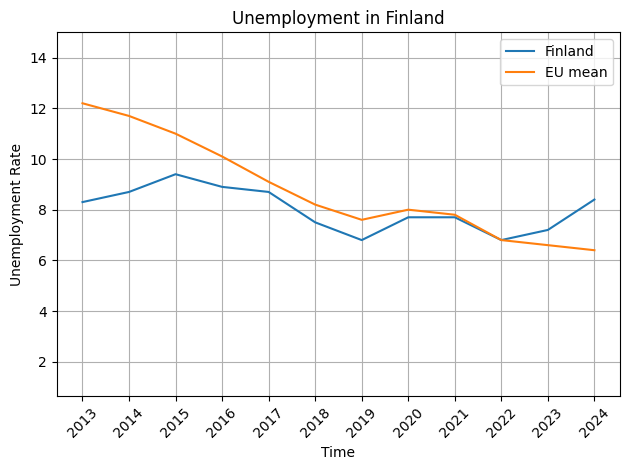

In [28]:
unemployment_table = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/unemployment/unemployment.csv")

states = unemployment_table["Geopolitical entity (reporting)"].unique()
y_min = unemployment_table["OBS_VALUE"].min()
y_max = unemployment_table["OBS_VALUE"].max()
padding = (y_max - y_min) * 0.05
y_min -= padding
y_max += padding
for state in states:
    if state=="Finland":
        country_df = unemployment_table[unemployment_table["Geopolitical entity (reporting)"] == state]
        eu_mean=unemployment_table[unemployment_table["Geopolitical entity (reporting)"] == "Euro area – 20 countries (from 2023)"]

        state_line, = plt.plot(country_df["TIME_PERIOD"], country_df["OBS_VALUE"], label=state)
        eu_line, = plt.plot(eu_mean["TIME_PERIOD"], eu_mean["OBS_VALUE"], label="EU mean")

        plt.grid()
        plt.title(f"Unemployment in {state}")
        plt.xlabel("Time")
        plt.ylabel("Unemployment Rate")
        if state=="Finland":
            plt.ylim(y_min,15)
        else:
            plt.ylim(y_min, y_max)
        years = sorted(unemployment_table["TIME_PERIOD"].unique())
        plt.xticks(years, rotation=45)
        plt.tight_layout()
        plt.legend() 

        output_dir = os.path.join("..", "Images", "Countries", state)
        file_name = f"unemployment_change_{state}.png"
        file_path = os.path.join(output_dir, file_name)

        if os.path.isdir(output_dir):
            plt.savefig(file_path)
        else:
            print(f"Directory not found for {state}: {output_dir}")

        plt.show()



### Crime rate in countries

C:\Users\adami\AppData\Local\Temp\ipykernel_29484\2962517336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)


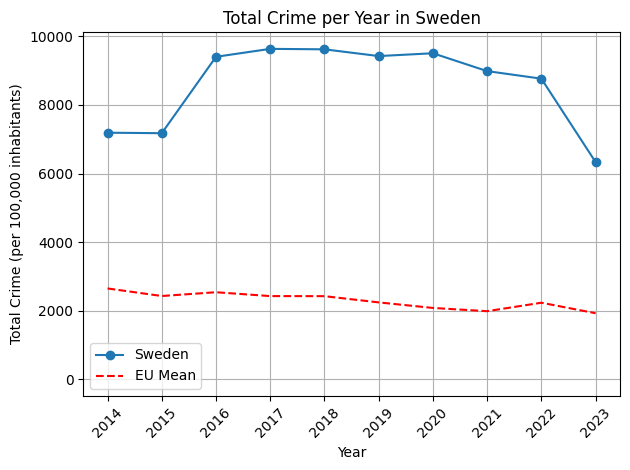

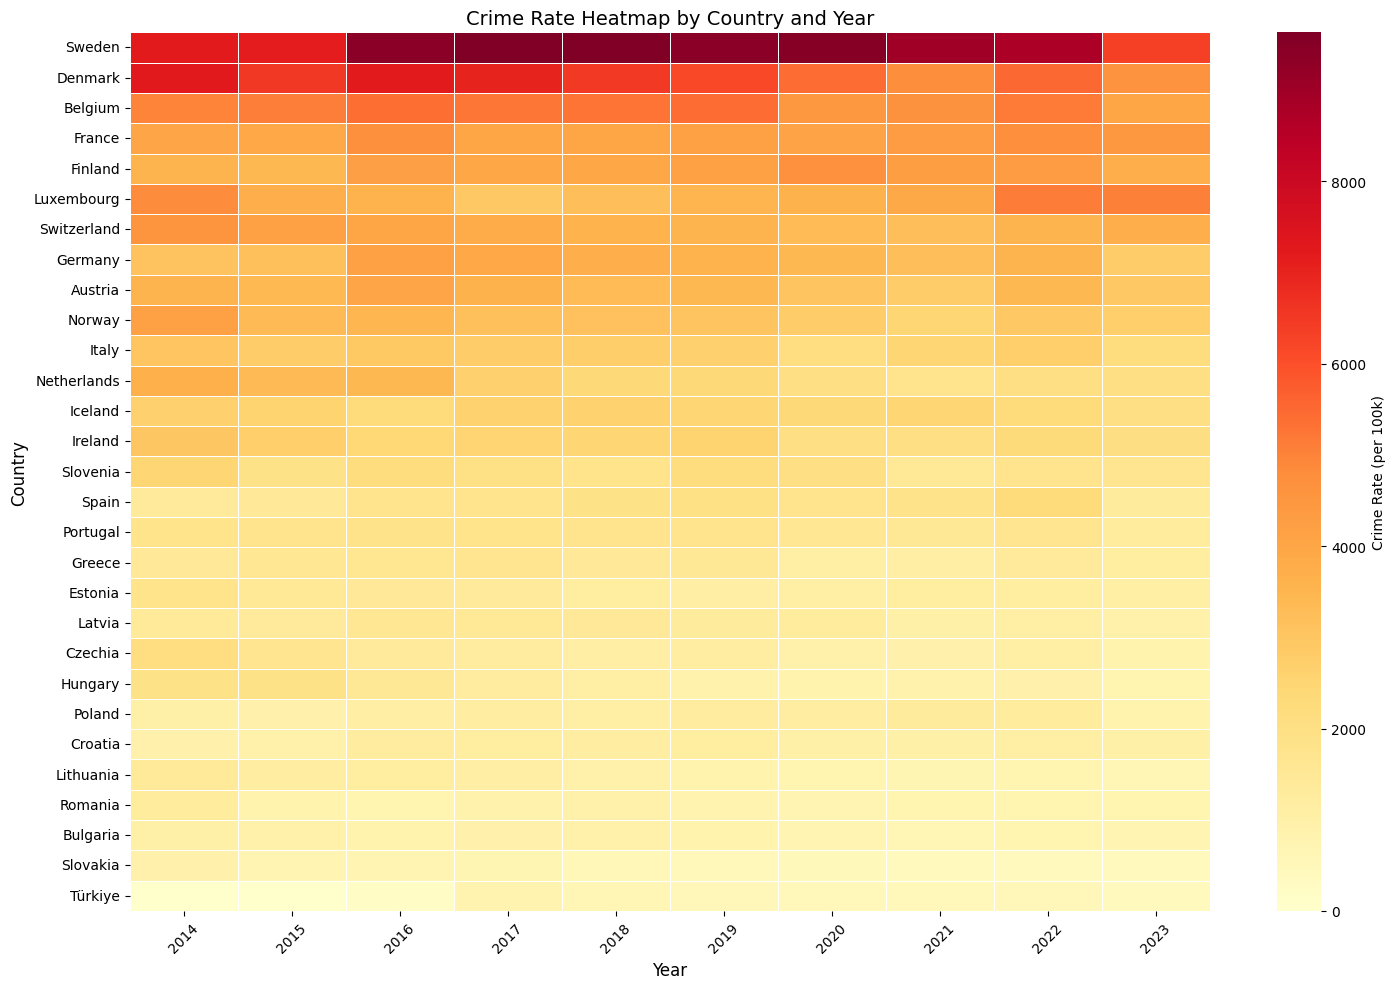

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country,,,,,,,,,,
Sweden,0.039912,0.042703,0.045443,0.051554,0.054732,0.057514,0.057723,0.055751,0.053229,0.050871
Denmark,0.041410,0.043179,0.046816,0.049362,0.050801,0.052085,0.052812,0.053861,0.054136,0.060135
Belgium,0.036681,0.037360,0.039857,0.041096,0.041501,0.042639,0.043917,0.044624,0.045628,0.051658
France,0.041729,0.045252,0.046448,0.046732,0.051534,0.052606,0.054425,0.056841,0.058434,0.059858
Finland,0.022358,0.023355,0.024263,0.026536,0.027344,0.028519,0.030063,0.032027,0.034323,0.038595
Luxembourg,0.062731,0.064710,0.068752,0.074239,0.077090,0.078048,0.081246,0.086478,0.089737,0.101865
Switzerland,0.081495,0.081828,0.082778,0.087509,0.088136,0.088344,0.088730,0.091596,0.092097,0.092949
Germany,0.047376,0.049944,0.058906,0.063886,0.066536,0.069129,0.071793,0.073505,0.076394,0.085559
Austria,0.063388,0.065973,0.073518,0.077328,0.078528,0.078787,0.079338,0.080535,0.082581,0.092541


Correlation Index Between Crime Rate and Non-EU Population for Each Country:
Country
Sweden         0.597546
Denmark       -0.849494
Belgium       -0.672495
France         0.503250
Finland        0.346870
Luxembourg     0.426231
Switzerland   -0.815063
Germany       -0.177908
Austria       -0.546449
Norway        -0.867409
Italy         -0.698448
Netherlands   -0.895740
Iceland       -0.777960
Ireland       -0.749169
Slovenia      -0.669198
Spain          0.064881
Portugal      -0.870211
Greece        -0.913176
Estonia       -0.000502
Latvia         0.691287
Czechia       -0.557078
Hungary       -0.889046
Poland         0.364283
Croatia       -0.170344
Lithuania     -0.505331
Romania       -0.208721
Bulgaria      -0.728676
Slovakia      -0.929461
Türkiye        0.197058
dtype: float64


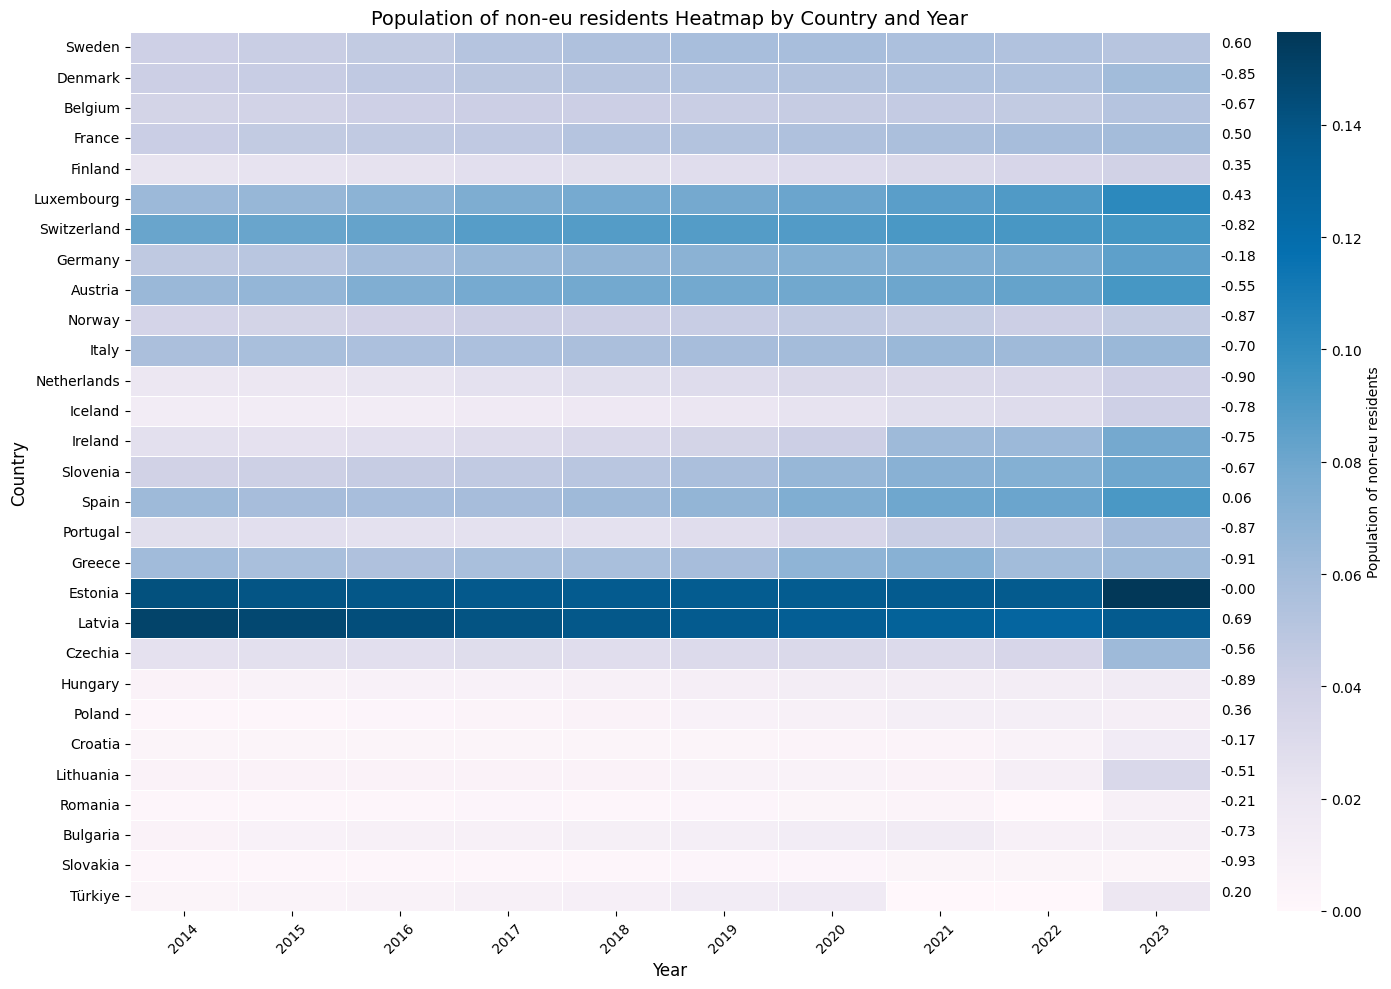

In [ ]:
crime_table = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/crime/crime_statistics.csv")
filtered = crime_table[crime_table["Unit of measure"] == "Per hundred thousand inhabitants"]
filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)
years = sorted(filtered["TIME_PERIOD"].unique())
states=crime_table["Geopolitical entity (reporting)"].unique()
grouped = (
    filtered.groupby(["Geopolitical entity (reporting)", "TIME_PERIOD"])["OBS_VALUE"]
    .sum()
    .reset_index()
    .rename(columns={
        "TIME_PERIOD": "Year",
        "Geopolitical entity (reporting)": "Country",
        "OBS_VALUE": "Total_Crime"
    })
)
#print(crime_table["Geopolitical entity (reporting)"].unique())
eu_data = grouped[grouped["Country"].isin(states)]
eu_mean = (
    eu_data.groupby("Year")["Total_Crime"]
    .mean()
    .reindex(years, fill_value=0)
    .reset_index()
    .rename(columns={"Total_Crime": "EU_Mean"})
)

y_min = grouped["Total_Crime"].min()
y_max = grouped["Total_Crime"].max()
padding = (y_max - y_min) * 0.05
y_min -= padding
y_max += padding

for state in grouped["Country"].unique():
    if state=="Sweden":
      country_data = (
          grouped[grouped["Country"] == state]
          .set_index("Year")
          .reindex(years, fill_value=0)
          .reset_index()
      )

      plt.figure()
      plt.plot(country_data["Year"], country_data["Total_Crime"], label=state, marker='o')
      plt.plot(eu_mean["Year"], eu_mean["EU_Mean"], label="EU Mean", linestyle='--', color='red')

      plt.title(f"Total Crime per Year in {state}")
      plt.xlabel("Year")
      plt.ylabel("Total Crime (per 100,000 inhabitants)")
      plt.ylim(y_min, y_max)
      plt.xticks(years, rotation=45)
      plt.grid(True)
      plt.legend()
      plt.tight_layout()

      #optional save:

      #output_dir = os.path.join("..", "Images", "Countries", state)
      #file_name = f"crime_rate_{state}.png"
      #file_path = os.path.join(output_dir, file_name)
      #if os.path.isdir(output_dir):
      #    plt.savefig(file_path)
      #else:
      #    print(f"Directory not found for {state}: {output_dir}")

      plt.show()






def draw_choropleth(data, column,range=None,save_name=None,title="",color_scheme=None):
  if color_scheme is None:
    cmap = "Plasma"
  else:
    cmap = color_scheme
    
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range,
      color_continuous_scale=cmap
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      color_continuous_scale=cmap
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  fig.show()

country_iso_dict = {
    'Albania': 'ALB',
    'Austria': 'AUT',
    'Bosnia and Herzegovina': 'BIH',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Switzerland': 'CHE',
    'Cyprus': 'CYP',
    'Czechia': 'CZE',
    'Germany': 'DEU',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Greece': 'GRC',
    'Spain': 'ESP',
    'Finland': 'FIN',
    'France': 'FRA',
    'Croatia': 'HRV',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Iceland': 'ISL',
    'Italy': 'ITA',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Latvia': 'LVA',
    'Montenegro': 'MNE',
    'North Macedonia': 'MKD',
    'Malta': 'MLT',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Serbia': 'SRB',
    'Sweden': 'SWE',
    'Slovenia': 'SVN',
    'Slovakia': 'SVK',
    'Türkiye': 'TUR'
}



selected_year=2016
map_data = grouped[grouped["Year"] == selected_year].copy()
map_data['iso_alpha'] = map_data['Country'].map(country_iso_dict)
map_data.set_index("iso_alpha", inplace=True)
draw_choropleth(
      data=map_data,
      column="Total_Crime",
      title=f"Total Crime per 100,000 Inhabitants in {selected_year}",
      color_scheme=["white","red","darkred"]
  )

#Remaining code in this cell improved and fixed by Erik 
year_offset = 4
def get_citizenship_ratio(table,country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(table,citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_ratio(table,country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")



countries_to_remove = [
    'England and Wales', 'Scotland (NUTS 2021)', 'Liechtenstein', 
    'Northern Ireland (UK) (NUTS 2021)', 'Malta', 'Serbia', 'Kosovo*', 'Cyprus', 'Albania', 
    'Montenegro', 'North Macedonia'
]

country_order = list(grouped.groupby("Country")["Total_Crime"].mean().sort_values(ascending=False).index)
country_order = [country for country in country_order if country not in countries_to_remove]

heatmap_data = grouped.pivot_table(
    index="Country",
    columns="Year",
    values="Total_Crime",
    fill_value=0
)
heatmap_data = heatmap_data.drop(index=countries_to_remove, errors='ignore')
heatmap_data = heatmap_data.loc[country_order]

def draw_heatmap(table, cmap, label, title, correlation=None):
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        table,
        annot=False,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"label": label}
    )

    if correlation is not None:
        for y, country in enumerate(table.index):
            if country in correlation.index:  # Ensure the country exists in the correlation data
                coef = correlation[country]
                plt.text(
                    x=table.shape[1] + 0.1 ,
                    y=y + 0.5,
                    s=f"{coef:.2f}", 
                    color="black", 
                    fontsize=10 
                )

    plt.title(title, fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

draw_heatmap(heatmap_data,"YlOrRd","Crime Rate (per 100k)", "Crime Rate Heatmap by Country and Year")

# non-eu population
# Done by Erik

table_raw = pd.read_csv("../Data/immigration/non_eu_population.csv")
table_population = table_raw.query("citizen != 'TOTAL' and year != 2024 and Country not in ['Malta', 'Liechtenstein', 'Cyprus']")

heatmap_population = table_population.pivot_table(
    index="Country",
    columns="year",
    values="non_eu_portion",
    fill_value=0
)
heatmap_population = heatmap_population.loc[country_order]

display(heatmap_population)

# Calculate and display correlation for each country
correlation_per_country = heatmap_data.corrwith(heatmap_population, axis=1)
print("Correlation Index Between Crime Rate and Non-EU Population for Each Country:")
print(correlation_per_country)


draw_heatmap(heatmap_population,"PuBu","Population of non-eu residents", "Population of non-eu residents Heatmap by Country and Year",correlation_per_country)



#### GDP change


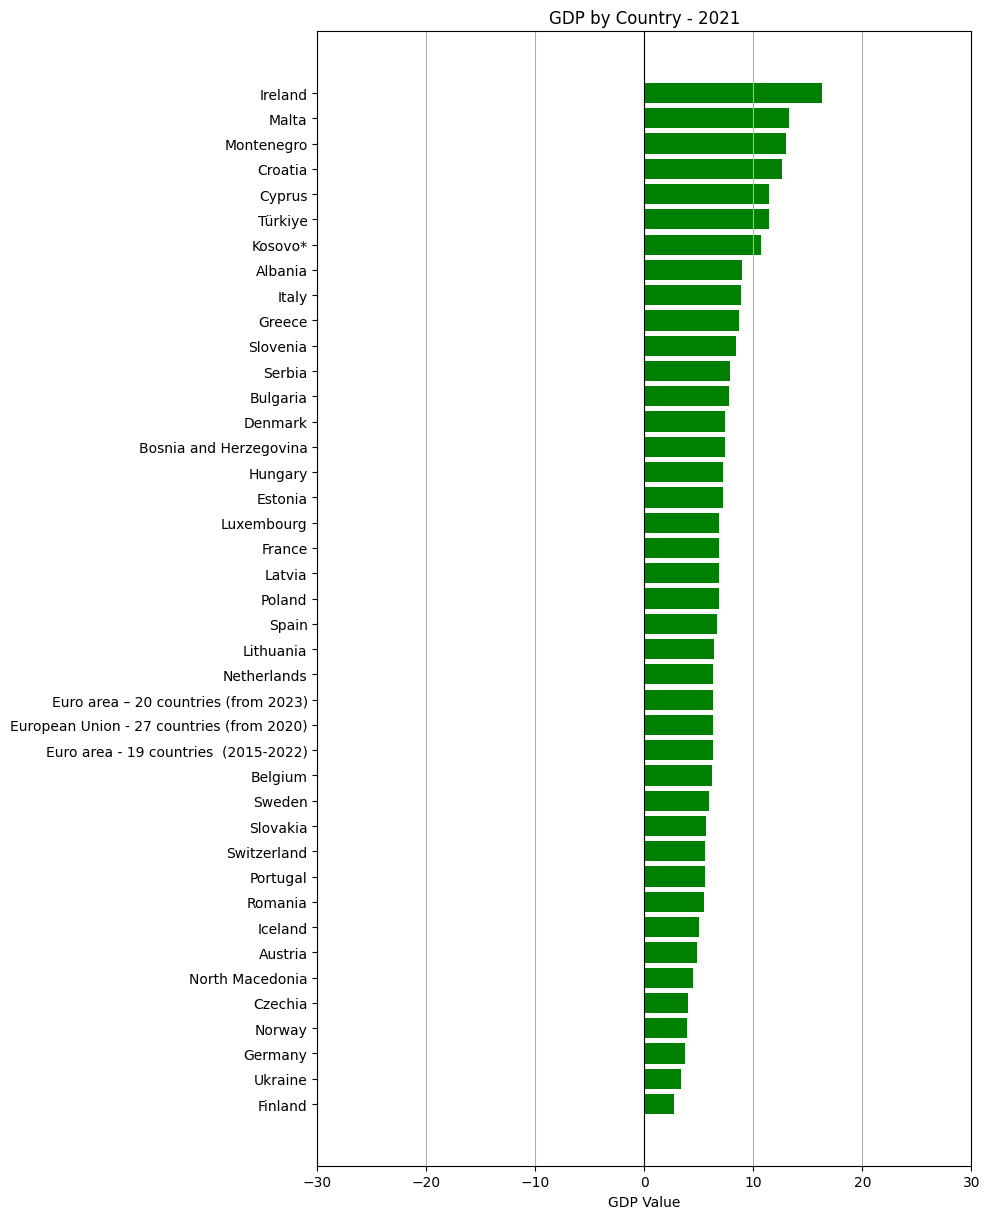

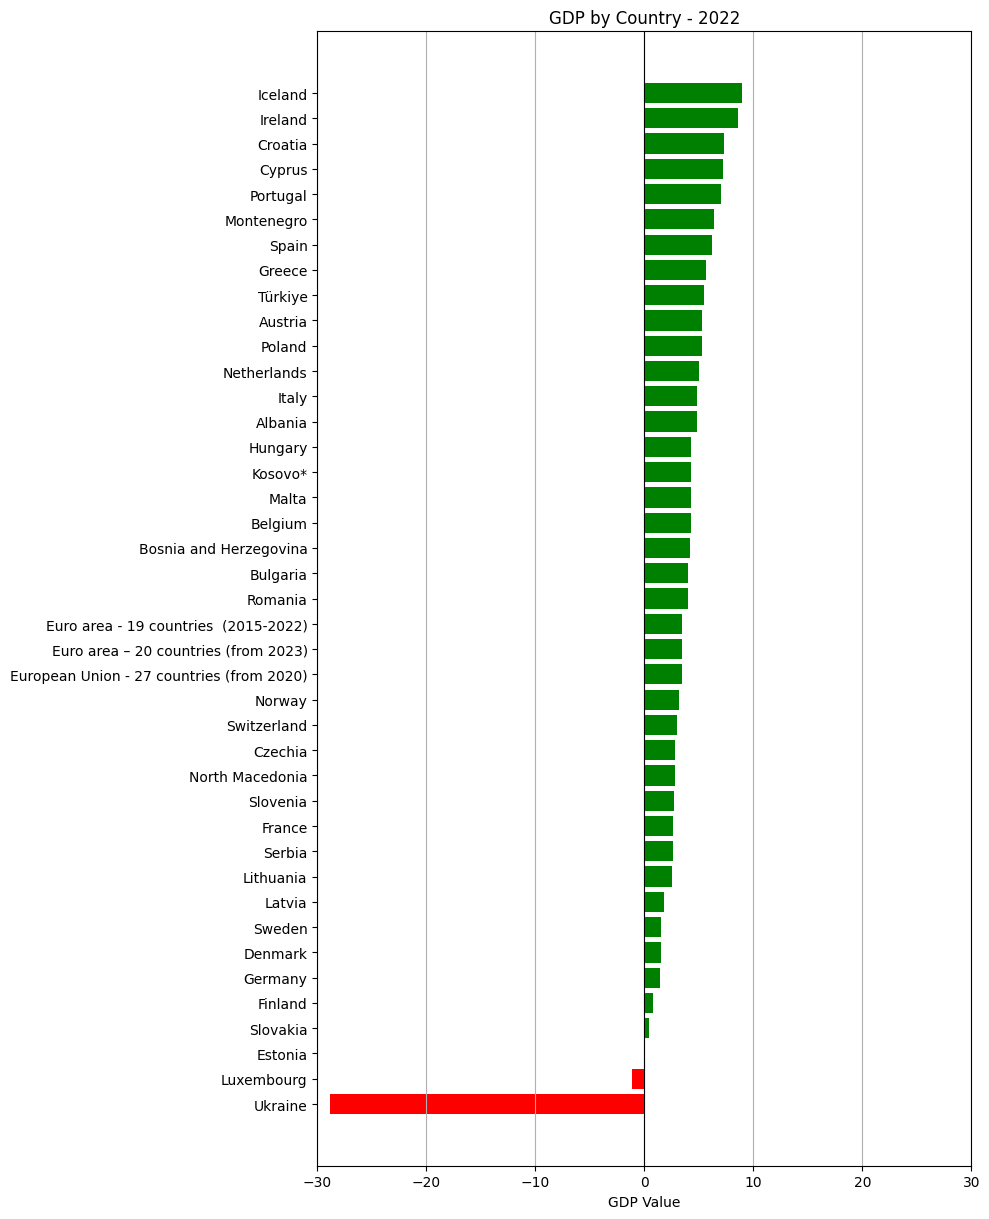

In [4]:
GDP_table = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/GDP.csv")

GDP_table["TIME_PERIOD"] = GDP_table["TIME_PERIOD"].astype(str)

GDP_table["OBS_VALUE"] = GDP_table["OBS_VALUE"].fillna(0)

y_range = (-30, 30)
selected_years="2021","2022"
for year in selected_years:
    year_df = GDP_table[GDP_table["TIME_PERIOD"] == year].copy()
    year_df = year_df.sort_values("OBS_VALUE")
    states = year_df["Geopolitical entity (reporting)"]
    values = year_df["OBS_VALUE"]
    colors = ['green' if val >= 0 else 'red' for val in values]
    plt.figure(figsize=(10, len(states) * 0.3))
    plt.barh(states, values, color=colors)
    plt.title(f"GDP by Country - {year}")
    plt.xlabel("GDP Value")
    plt.xlim(y_range)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Erik

# Adrian